In [1]:
# ! pip install tensorflow
# ! pip install graphviz
# ! pip install pydot

import numpy as np
from tensorflow.keras import layers, losses, optimizers, models, metrics
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import ReLU
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger



def double_conv(filters, kernel_size=3, batch_norm=True):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(filters, kernel_size, activation='relu', padding='same'))
    if batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters, kernel_size, activation='relu', padding='same'))
    if batch_norm:
        model.add(layers.BatchNormalization())
    return model


def upsample_conv(filters, kernel_size=2, strides=2, batch_norm=True):
    model = tf.keras.Sequential()
    model.add(layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding='same'))
    if batch_norm:
        model.add(layers.BatchNormalization())
    return model


def unet(num_layers=4, base_filters=64, input_shape=(256, 256, 3), num_classes=1, batch_norm=True):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    # Down-sampling path
    downsamples = []
    for i in range(num_layers):
        filters = base_filters * (2 ** i)
        x = double_conv(filters, batch_norm=batch_norm)(x)
        downsamples.append(x)
        x = layers.MaxPooling2D(2)(x)

    # Bottom of the U-Net
    filters = base_filters * (2 ** num_layers)
    x = double_conv(filters, batch_norm=batch_norm)(x)

    # Up-sampling path
    for i in reversed(range(num_layers)):
        filters = base_filters * (2 ** i)
        x = upsample_conv(filters, batch_norm=batch_norm)(x)
        x = layers.Concatenate()([x, downsamples[i]])
        x = double_conv(filters, batch_norm=batch_norm)(x)

    # Output
    x = layers.Conv2D(num_classes, 1, activation='tanh', padding='same')(x)

    model = Model(inputs, x)
    return model


2023-02-23 10:26:34.523541: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
! pip install keras-unet

In [ ]:
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape=(32, 32, 8),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='relu')
model.summary()

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, LeakyReLU, Input

def CNN(num_hidden_layers, num_filters, h,w,in_channels, out_channels, kernel_size):
    model = Sequential()
    
    # Add input layer with shape (h, w, in_channels)
    model.add(Input((h, w, in_channels)))
    
    model.add(Conv2D(num_filters, kernel_size=(1, 1),\
                          padding='valid', activation="tanh"))
    
    # Add additional hidden layers
    for i in range(1, num_hidden_layers):
        model.add(Conv2D(num_filters*((i+1)), kernel_size=(kernel_size, kernel_size),\
                          padding='valid', activation="tanh"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten the output of the final convolutional layer
    model.add(Flatten())
    
    # Add a fully connected layer with output size h * w * out_channels
    model.add(Dense(h * w * out_channels, activation="relu"))
    
    # Reshape the output of the fully connected layer to the desired output shape
    model.add(Reshape((h, w, out_channels)))
    
    return model
model = CNN(3, 32, 32, 32, 8, 1, kernel_size=5)
model.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 32, 32, 32)        288       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 28, 28, 64)        51264     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 10, 10, 96)        153696    
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 5, 5, 96)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 2400)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)            

In [14]:
import tensorflow as tf

if tf.test.is_gpu_available():
    print("GPU available for use")
else:
    print("GPU not available for use")


GPU available for use


2023-02-22 17:24:37.096133: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-22 17:24:37.098174: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-22 17:24:37.099851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-22 17:24:37.099922: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-22 17:24:37.099994: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
20

In [15]:
import time 
starttime = time.time()
model.predict(np.random.rand(10, 32, 32, 8))
print (time.time() - starttime)

0.08546948432922363


In [ ]:
import numpy as np
import tensorflow
import os 
import glob 
from tensorflow.keras.losses import MeanAbsoluteError, BinaryCrossentropy


# Create CSVLogger callback with specified filename
from tensorflow.keras.callbacks import Callback

class ComputeMetrics(Callback):
    def on_epoch_end(self, epoch, model, logs):
        logs['CSR_train_data'] = compute_CSR(model.predict)  # replace it with your metrics

    
class CustomDataGenerator(tensorflow.keras.utils.Sequence):
    def __init__(self, data_dir, num_samples, batch_size=32, shuffle=True):
        self.data_dir = data_dir
        self.num_samples = num_samples
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(1, num_samples+1)
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(self.num_samples / float(self.batch_size)))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        x_batch = []
        y_batch = []
        for i in indexes:
            file_x = os.path.join(self.data_dir, '{}_x.npy'.format(i))
            file_y = os.path.join(self.data_dir, '{}_y.npy'.format(i))
            x = np.load(file_x)
            y = np.load(file_y)
            x_batch.append(x)
            y_batch.append(y)
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)
        return (x_batch), (y_batch)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

            
def my_loss_fn(y_true, y_pred):
    global M
    squared_difference = tf.square((y_true) - (y_pred))
    return tf.reduce_mean(squared_difference, axis=-1)             

for n_depth in [1]:# [1,2,3,4,5,6]:


    # Generate some random training data
#     input_shape = (32, 32, 3)
    output_channels = 1
#     x_train = np.random.rand(num_samples, *input_shape)
#     y_train = np.random.rand(num_samples, input_shape[0], input_shape[1], output_channels)

    # Create the model
    input_shape = (32, 32, 8)
    model = unet(num_layers=n_depth, base_filters=64, input_shape=input_shape, num_classes=output_channels, batch_norm=True)
    
    model = CNN(4, 32, 32, 32, 8, 1, kernel_size=3)
#     model = CNN(3, 16, 32, 32, 8, 8, kernel_size=3)
#     model = custom_unet(
#         input_shape=(32, 32, 8),
#         use_batch_norm=True,
#         num_classes=1,
#         filters=16,
#         dropout=0,
#         output_activation='relu')
    model.summary()

    print (model.summary())

    # Compile the model with a mean squared error loss and an Adam optimizer
    loss_fn = my_loss_fn # losses.MeanSquaredError()
#     loss_fn = "mae"
    
#     loss_fn = "mse"
#     optimizer = optimizers.Adam(1e-2)
#     optimizer = optimizers.RMSprop()
    optimizer = "sgd"
#     metrics = metrics.MeanAbsoluteError()
    model.compile(optimizer=optimizer, loss=loss_fn, metrics="mape")

    # Train the model
    batch_size = 32
    epochs = 10
    earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='auto')

#     # Train the model with early stopping
#     history = model.fit(x_train, y_train, validation_data = (x_train, y_train),\
#                         batch_size=batch_size, epochs=epochs, callbacks=[earlystop])


    # Evaluate the model on some validation data
#     x_val = np.random.rand(num_samples, *input_shape)
#     y_val = np.random.rand(num_samples, input_shape[0], input_shape[1], output_channels)
#     val_loss, val_mae = model.evaluate(x_val, y_val, batch_size=batch_size)
#     print(f"Validation loss: {val_loss:.4f}, validation mean absolute error: {val_mae:.4f}")


#     from tensorflow.keras.utils import plot_model
#     model = unet(num_layers=n_depth, base_filters=64, input_shape=(256, 256, 3), num_classes=1, batch_norm=True)
#     plot_model(model, to_file=str(n_depth) + 'unet.png', show_shapes=False, show_layer_names=False) # , show_layer_activations=False)

           
    train_data_folder = "training_data_8_4_1"
    validation_data_folder = "validation_data_8_4_1"

    num_train = len(glob.glob(train_data_folder + "/*_x.npy")) 
    num_validation = len(glob.glob(validation_data_folder + "/*_x.npy")) 

    
    train_gen = CustomDataGenerator(data_dir=train_data_folder, \
                                    num_samples=num_train-1, batch_size=batch_size, shuffle=True)
    validation_gen = CustomDataGenerator(data_dir=validation_data_folder, \
                                         num_samples=num_validation-1, batch_size=batch_size, shuffle=True)
    
        
    filename = str(n_depth) + '_validation_loss.csv'

    csv_logger = CSVLogger(filename)
    tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir="log_dir")


    earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='auto')
    model.fit(train_gen, validation_data=validation_gen, epochs=epochs, callbacks=[earlystop, csv_logger,\
                                                                                   tensorboard_callback],\
                                                                             workers=6)
            

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 32, 32, 32)        288       
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 13, 13, 96)        55392     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 6, 6, 96)          0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 4, 4, 128)         110720    
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 2, 2, 128)       

2023-02-23 10:37:53.345421: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-02-23 10:37:53.345443: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-02-23 10:37:53.345518: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2023-02-23 10:37:53.345530: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


  9/462 [..............................] - ETA: 11s - loss: 92128.1328 - mape: 311659992.4444

2023-02-23 10:37:58.776102: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-02-23 10:37:58.776125: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-02-23 10:37:58.776219: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2023-02-23 10:37:58.826134: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-02-23 10:37:58.827313: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-02-23 10:37:58.828457: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-02-23 10:37:58.829138: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: log_dir/train/plugins/profile/2023_02_23_10_37_58


462/462 [==============================] - 44s 83ms/step - loss: 61183.3031 - mape: 7868596653.2613 - val_loss: 41657.8633 - val_mape: 9063080960.0000
Epoch 2/10
462/462 [==============================] - 33s 71ms/step - loss: 44422.8045 - mape: 14302489442.9719 - val_loss: 41737.5898 - val_mape: 9225142272.0000
Epoch 3/10
462/462 [==============================] - 33s 71ms/step - loss: 44381.9636 - mape: 14474349245.0972 - val_loss: 40392.5781 - val_mape: 9101650944.0000
Epoch 4/10
462/462 [==============================] - 33s 70ms/step - loss: 42949.8458 - mape: 15125997579.0583 - val_loss: 39225.5430 - val_mape: 9789172736.0000
Epoch 5/10
462/462 [==============================] - 33s 71ms/step - loss: 42063.0343 - mape: 15661696878.0302 - val_loss: 39307.8555 - val_mape: 9962255360.0000
Epoch 6/10
462/462 [==============================] - 32s 69ms/step - loss: 42325.3480 - mape: 15950558776.3974 - val_loss: 36918.5977 - val_mape: 9962116096.0000
Epoch 7/10
462/462 [==============

In [21]:
%tensorboard --logdir log_dir

UsageError: Line magic function `%tensorboard` not found.


In [9]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 32, 32, 10)        730       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 16, 16, 10)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 15)        1365      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 8, 8, 15)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 8, 8, 20)          2720      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 4, 4, 20)          0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 4, 4, 25)         

In [13]:
from smartprint import smartprint as sprint 
import matplotlib.pyplot as plt 
import numpy as np 

for x,y in train_gen:
    print (x.shape, y.shape)
    print (np.max(x[0]))
    break

(32, 32, 32, 8) (32, 32, 32, 1)
1246.0


In [14]:
(np.sum((np.sum(x, axis=1)), axis=1)).shape
y = model.predict(x)
sprint (y.shape)

y.shape : (32, 32, 32, 1)


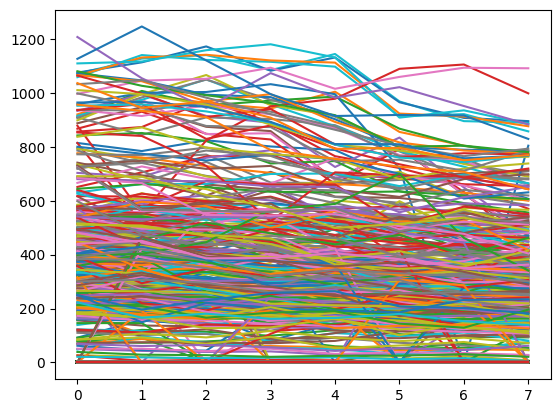

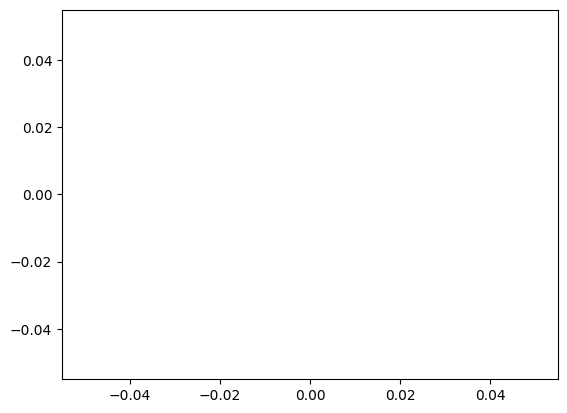

In [15]:
for k in range(32):
    for j in range(32):
        for i in range(1):
            if np.random.rand() < 1:
                plt.plot((x[i,j,k,:]).tolist())
plt.show()


for k in range(32):
    for j in range(32):
        for i in range(1):
            if np.random.rand() < 1:
                plt.plot((y[i,j,k,:]).tolist())
plt.show()

In [16]:
(y[:,j,k,:]).tolist()

[[0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0]]

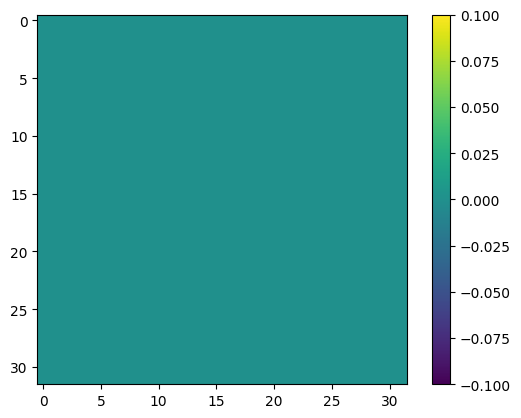

In [23]:
plt.imshow(y[6, :, :, 0])
plt.colorbar()

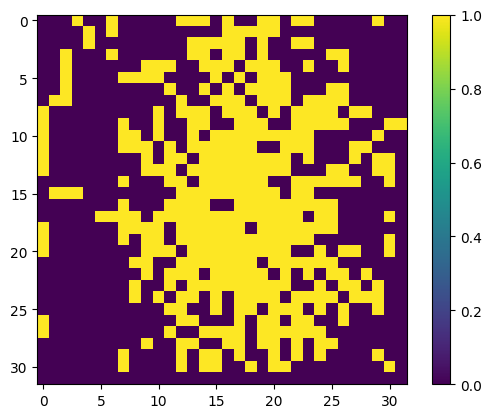

In [15]:
# plt.imshow(x[0,:,:,0])
# plt.show()

M = x[0,:,:,0]
M[M!=0] = 1
M[M<1] = 0
plt.imshow(M)
plt.colorbar()



In [79]:
import glob 
import numpy as np
from tqdm import tqdm 
from smartprint import smartprint as sprint
from scipy.spatial import minkowski_distance_p
import random
import matplotlib.pyplot as plt

def estimate_y_thresh(model_predict, training_data_folder, tnl=8, N=1000):
    """
    tnl: temporal_neighbour_limit 
    model_predict = model.predict    
    N: How many data points to use to estimate y_thresh
    """

    filenames = glob.glob(training_data_folder + "/*.npy")
    filenames = [f for f in filenames if "_x" in f]
    
    range_of_fnames = list(range(tnl+1, len(filenames)-tnl))
    random.shuffle(range_of_fnames)
                           
    dist_list = [] 
    prev_mean = -10000000

    total_count = 0 
    for i in tqdm(range_of_fnames[:N], desc="estimating y_thresh through random " + str(N) + \
                 " training points"):
        file = filenames[i]
        total_count += 1 
        n = str(i) 
        x = np.load(training_data_folder + "/"+ n +"_x" + ".npy") 
        y = np.load(training_data_folder + "/"+ n +"_y" + ".npy") 
        
        neighbours = [] # since we should minimise the number of calls to model.predict
        for j in range(-tnl, tnl):
            neigh = int(n) + j
            x_hat = np.load(training_data_folder + "/"+ str(neigh) + "_x" + ".npy") 
            y_hat = np.load(training_data_folder + "/"+ str(neigh) + "_y" + ".npy")
                
            x_hat = x_hat.reshape(tuple([-1] + list(x_hat.shape)))

            neighbours.append(x_hat)
        
        prediction = model.predict(np.vstack(tuple(neighbours)))

        diff = prediction - y 

        dist = minkowski_distance_p(prediction.reshape((prediction.shape[0], -1)),\
                                    y.reshape((1, -1)), np.inf)
#         print (dist.shape)

        dist_list = dist_list + dist.flatten().tolist()
        
        percent_diff = np.abs( (np.mean(dist_list) - prev_mean) / prev_mean )
        if percent_diff < 0.0001 and total_count > 100: 
            break
            
        prev_mean = np.mean(dist_list)
        
    plt.hist(dist_list)    
    return np.mean(dist_list), np.std(dist_list), np.max(dist_list), i, percent_diff

# compute CSR 
def compute_CSR(model_predict, training_data_folder, y_thresh=30, tnl=8, N=1000):
    """
    tnl: temporal_neighbour_limit 
    model_predict = model.predict    
    """
    count_CS = []
    cache_dict = {} # to reduce the number of file reads 
    hit, miss = 0, 0 
    filenames = glob.glob(training_data_folder + "/*.npy")
    filenames = [f for f in filenames if "_x" in f]
    
    range_of_fnames = list(range(tnl+1, len(filenames)-tnl))
    random.shuffle(range_of_fnames)
    
    prev_CSR = 100000000
    
    total_count = 0 
    for i in tqdm(range_of_fnames[:N], desc="computing CSR for training dataset"):
        total_count += 1 
        
        file = filenames[i]
        n = str(i) 
        if int(n) in cache_dict:
            x,y = cache_dict[int(n)]
            hit += 1 
        else:
            x = np.load(training_data_folder + "/"+ n +"_x" + ".npy") 
            y = np.load(training_data_folder + "/"+ n +"_y" + ".npy") 
            cache_dict[int(n)] = x,y
            miss += 1 
        
        neighbours = [] # since we should minimise the number of calls to model.predict
        for j in range(-tnl, tnl):
            neigh = int(n) + j
            if neigh in cache_dict:
                x_hat, y_hat = cache_dict[neigh]
                hit += 1
            else:
                x_hat = np.load(training_data_folder + "/"+ str(neigh) + "_x" + ".npy") 
                y_hat = np.load(training_data_folder + "/"+ str(neigh) + "_y" + ".npy")
                cache_dict[neigh] = x_hat, y_hat
                miss += 1 
                
            x_hat = x_hat.reshape(tuple([-1] + list(x_hat.shape)))

            neighbours.append(x_hat)
        
        prediction = model.predict(np.vstack(tuple(neighbours)))

        diff = prediction - y 
        dist = minkowski_distance_p(prediction.reshape((prediction.shape[0], -1)), \
                                    y.reshape((1, -1)), np.inf)
        if np.any(dist > y_thresh):
            count_CS.append(x)
            
        percent_diff = np.abs( len(count_CS)/total_count - prev_CSR)
        if percent_diff < 0.0001 and total_count>100: 
            break            
        prev_CSR = len(count_CS)/total_count

        del cache_dict[int(n)-tnl] # no need to retain the files which have already been read 
        
        if np.random.rand() < 0.0005 : 
            sprint (hit, miss, len(cache_dict))
            sprint (prediction.shape, y.shape, diff.shape, len(count_CS))
            
    return len(count_CS), total_count, prev_CSR



# compute CSR 
def compute_criticality(model_predict, training_data_folder, y_thresh=30, tnl=8, N=1000):
    """
    tnl: temporal_neighbour_limit 
    model_predict = model.predict    
    """
    count_CS = []
    cache_dict = {} # to reduce the number of file reads 
    hit, miss = 0, 0 
    filenames = glob.glob(training_data_folder + "/*.npy")
    filenames = [f for f in filenames if "_x" in f]
    
    range_of_fnames = list(range(tnl+1, len(filenames)-tnl))
    random.shuffle(range_of_fnames)
    
    
    total_count = 0 
    for i in (range_of_fnames[:N]): #, desc="computing CSR for training dataset"):
        total_count += 1 
        
        file = filenames[i]
        n = str(i) 
        if int(n) in cache_dict:
            x,y = cache_dict[int(n)]
            hit += 1 
        else:
            x = np.load(training_data_folder + "/"+ n +"_x" + ".npy") 
            y = np.load(training_data_folder + "/"+ n +"_y" + ".npy") 
            cache_dict[int(n)] = x,y
            miss += 1 
        
        neighbours = [] # since we should minimise the number of calls to model.predict
        for j in range(-tnl, tnl):
            neigh = int(n) + j
            if neigh in cache_dict:
                x_hat, y_hat = cache_dict[neigh]
                hit += 1
            else:
                x_hat = np.load(training_data_folder + "/"+ str(neigh) + "_x" + ".npy") 
                y_hat = np.load(training_data_folder + "/"+ str(neigh) + "_y" + ".npy")
                cache_dict[neigh] = x_hat, y_hat
                miss += 1 
                
            x_hat = x_hat.reshape(tuple([-1] + list(x_hat.shape)))

            neighbours.append(x_hat)
        
        prediction = model.predict(np.vstack(tuple(neighbours)))

        diff = prediction - y 
        dist = minkowski_distance_p(prediction.reshape((prediction.shape[0], -1)), \
                                    y.reshape((1, -1)), np.inf)
        if np.any(dist > y_thresh):
            count_CS.append( np.count_nonzero(dist>y_thresh) )

        del cache_dict[int(n)-tnl] # no need to retain the files which have already been read 
        
        if np.random.rand() < 0.0005 : 
            sprint (hit, miss, len(cache_dict))
            sprint (prediction.shape, y.shape, diff.shape, len(count_CS))
            
    return count_CS


# compute CSR 
def compute_criticality_smooth(model_predict, training_data_folder, y_thresh=30, tnl=8, N=1000):
    """
    tnl: temporal_neighbour_limit 
    model_predict = model.predict    
    """
    count_CS = []
    cache_dict = {} # to reduce the number of file reads 
    hit, miss = 0, 0 
    filenames = glob.glob(training_data_folder + "/*.npy")
    filenames = [f for f in filenames if "_x" in f]
    
    range_of_fnames = list(range(tnl+1, len(filenames)-tnl))
    random.shuffle(range_of_fnames)
    
    
    total_count = 0 
    for i in (range_of_fnames[:N]): #, desc="computing CSR for training dataset"):
        total_count += 1 
        
        file = filenames[i]
        n = str(i) 
        if int(n) in cache_dict:
            x,y = cache_dict[int(n)]
            hit += 1 
        else:
            x = np.load(training_data_folder + "/"+ n +"_x" + ".npy") 
            y = np.load(training_data_folder + "/"+ n +"_y" + ".npy") 
            cache_dict[int(n)] = x,y
            miss += 1 
        
        neighbours = [] # since we should minimise the number of calls to model.predict
        for j in range(-tnl, tnl):
            neigh = int(n) + j
            if neigh in cache_dict:
                x_hat, y_hat = cache_dict[neigh]
                hit += 1
            else:
                x_hat = np.load(training_data_folder + "/"+ str(neigh) + "_x" + ".npy") 
                y_hat = np.load(training_data_folder + "/"+ str(neigh) + "_y" + ".npy")
                cache_dict[neigh] = x_hat, y_hat
                miss += 1 
                
            x_hat = x_hat.reshape(tuple([-1] + list(x_hat.shape)))

            neighbours.append(x_hat)
        
        prediction = model.predict(np.vstack(tuple(neighbours)))

        diff = prediction - y 
        dist = minkowski_distance_p(prediction.reshape((prediction.shape[0], -1)), \
                                    y.reshape((1, -1)), np.inf)

        count_CS.append( np.mean(dist) )

        del cache_dict[int(n)-tnl] # no need to retain the files which have already been read 
        
        if np.random.rand() < 0.0005 : 
            sprint (hit, miss, len(cache_dict))
            sprint (prediction.shape, y.shape, diff.shape, len(count_CS))
            
    return count_CS


def determine_y_thresh_by_maximising_variance_around_mean(mean_dist, max_dist):
    std = {}
    for i in tqdm(np.arange(0, max_dist, abs(0- max_dist)/30), desc="Finding y_thresh"):
        l = compute_criticality_smooth(model.predict, "training_data_8_4_1", y_thresh=i, tnl=8, N=2000)
        std[i] = np.std(l)
    sprint (std)
    return (std)
    
mean_thresh, std_thresh, max_thresh, n_required_to_converge, percent_diff = estimate_y_thresh\
                                                    (model.predict, "training_data_8_4_1", tnl=8)
var_dict = determine_y_thresh_by_maximising_variance_around_mean(mean_thresh, max_thresh) 
sprint (var_dict)
plt.show()
plt.plot( list(var_dict.keys()), list(var_dict.values()) )
plt.show()

# sprint ()
        
    
    


estimating y_thresh through random 1000 training points:   0%|                                     | 0/1000 [00:00<?, ?it/s]

estimating y_thresh through random 1000 training points:   3%|▊                           | 28/1000 [00:03<01:49,  8.86it/s]


KeyboardInterrupt: 

In [36]:
# Construct the input layer with no definite frame size.
from tensorflow.keras import layers
inp = layers.Input(shape=(None, 8))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = tensorflow.keras.models.Model(inp, x)
model.compile(
    loss=tensorflow.keras.losses.MAE, optimizer=tf.keras.optimizers.Adam(),
)


ValueError: Input 0 of layer conv_lst_m2d_22 is incompatible with the layer: expected ndim=5, found ndim=3. Full shape received: (None, None, 8)

In [35]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, None, 32, 32, 8)] 0         
_________________________________________________________________
conv_lst_m2d_19 (ConvLSTM2D) (None, None, 32, 32, 64)  461056    
_________________________________________________________________
batch_normalization_12 (Batc (None, None, 32, 32, 64)  256       
_________________________________________________________________
conv_lst_m2d_20 (ConvLSTM2D) (None, None, 32, 32, 64)  295168    
_________________________________________________________________
batch_normalization_13 (Batc (None, None, 32, 32, 64)  256       
_________________________________________________________________
conv_lst_m2d_21 (ConvLSTM2D) (None, None, 32, 32, 64)  33024     
_________________________________________________________________
conv3d_6 (Conv3D)            (None, None, 32, 32, 1)   1729